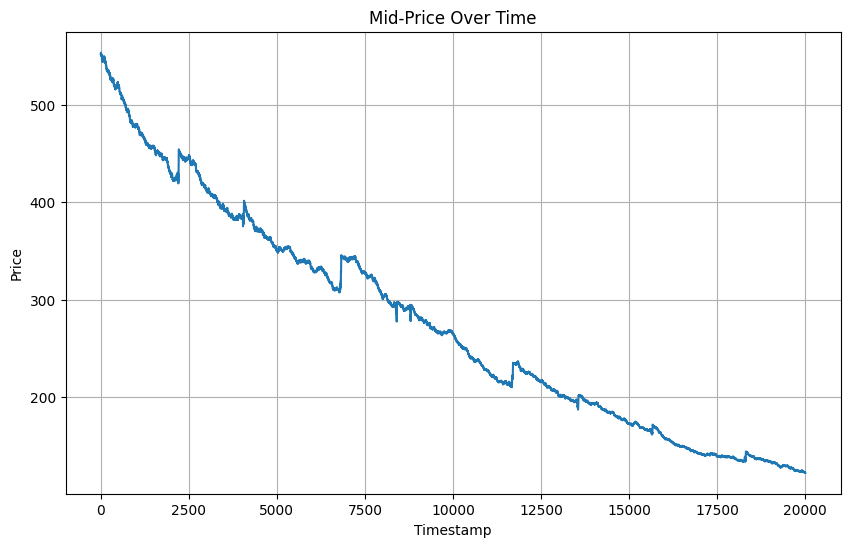

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Load SOBER data
sober_data = pd.read_csv('../data/SOBER.csv')

# Calculate mid prices and spreads
sober_data['Mid_Price'] = (sober_data['Bids'] + sober_data['Asks']) / 2

# Plot mid-price
plt.figure(figsize=(10, 6))
plt.plot(sober_data['Mid_Price'])
plt.title('Mid-Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load SOBER data
# Ensure this path is correct for your environment
try:
    sober_data = pd.read_csv('../data/SOBER.csv')
except FileNotFoundError:
    print("Error: 'SOBER.csv' not found. Please check the file path: '../data/SOBER.csv'")
    exit()


# Calculate mid prices and spreads
sober_data['Mid_Price'] = (sober_data['Bids'] + sober_data['Asks']) / 2
sober_data['Spread'] = sober_data['Asks'] - sober_data['Bids']

# Add a time index for plotting
# The original script unconditionally created 'Time_Index'. We'll stick to that for consistency.
sober_data['Time_Index'] = range(len(sober_data))
x_axis_col = 'Time_Index'

# Calculate returns
sober_data['Returns'] = sober_data['Mid_Price'].pct_change().fillna(0)

# Calculate standard volatility (classic rolling window, adjusted as per original script)
window_size = 50  # Size for volatility calculation
sober_data['Standard_Volatility_NOT_ADJUSTED'] = sober_data['Returns'].rolling(window=window_size).std() * np.sqrt(252)

# Adjust volatility by spread, handling potential division by zero or negative results
denominator = 10 - sober_data['Spread']
# Replace 0 or negative denominators with np.nan to result in np.nan volatility, preventing errors
denominator = denominator.where(denominator > 0, np.nan)
sober_data['Standard_Volatility'] = sober_data['Standard_Volatility_NOT_ADJUSTED'] / denominator

# Define the high volatility threshold
HIGH_VOLATILITY_THRESHOLD = 0.2

# Create figure with subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.5, 0.5], # Equal height for the two plots
    subplot_titles=['SOBER Mid Price', f'Standard Volatility (Periods > {HIGH_VOLATILITY_THRESHOLD} Highlighted)']
)

# Plot Mid Price
fig.add_trace(
    go.Scatter(
        x=sober_data[x_axis_col],
        y=sober_data['Mid_Price'],
        mode='lines',
        name='Mid Price',
        line=dict(color='blue')
    ),
    row=1, col=1
)

# Plot Standard Volatility
fig.add_trace(
    go.Scatter(
        x=sober_data[x_axis_col],
        y=sober_data['Standard_Volatility'],
        mode='lines',
        name='Standard Volatility',
        line=dict(color='purple')
    ),
    row=2, col=1
)

# Add volatility threshold line to the second subplot
fig.add_hline(
    y=HIGH_VOLATILITY_THRESHOLD,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Threshold ({HIGH_VOLATILITY_THRESHOLD})",
    annotation_position="bottom right",
    row=2, col=1
)

# Highlight periods of high volatility on both subplots
# Find the first valid index for Standard_Volatility (due to rolling window)
first_valid_vol_idx = sober_data['Standard_Volatility'].first_valid_index()

if first_valid_vol_idx is not None:
    in_high_vol_period = False
    highlight_start_x = None

    # Iterate from the first valid volatility index to the end of the dataframe
    for i in range(first_valid_vol_idx, len(sober_data)):
        current_x_value = sober_data.loc[i, x_axis_col]
        vol_value = sober_data.loc[i, 'Standard_Volatility']

        # Check if current volatility is valid (not NaN) and above the threshold
        is_currently_high_and_valid = pd.notna(vol_value) and vol_value > HIGH_VOLATILITY_THRESHOLD

        if is_currently_high_and_valid and not in_high_vol_period:
            # Start of a new high volatility period
            in_high_vol_period = True
            highlight_start_x = current_x_value
        elif (not is_currently_high_and_valid) and in_high_vol_period:
            # End of the current high volatility period
            # This triggers if:
            #   1. Volatility is valid but no longer high.
            #   2. Volatility becomes NaN (implicitly ending the high period).
            in_high_vol_period = False
            highlight_end_x = current_x_value # The period ends before this point
            if highlight_start_x is not None:
                for r_idx in [1, 2]: # Apply to both rows (subplots)
                    fig.add_vrect(
                        x0=highlight_start_x, x1=highlight_end_x,
                        fillcolor="rgba(255, 165, 0, 0.2)", # Semi-transparent orange
                        layer="below", line_width=0,
                        row=r_idx, col=1
                    )
            highlight_start_x = None # Reset for the next potential period

    # If the data series ends while still in a high volatility period
    if in_high_vol_period and highlight_start_x is not None:
        # The period extends to the very end of the data
        # For Time_Index, add 1 to x1 to make the rectangle cover the last point's "area"
        highlight_end_x = sober_data.loc[len(sober_data)-1, x_axis_col] + 1

        for r_idx in [1, 2]: # Apply to both rows (subplots)
            fig.add_vrect(
                x0=highlight_start_x, x1=highlight_end_x,
                fillcolor="rgba(255, 165, 0, 0.2)", # Semi-transparent orange
                layer="below", line_width=0,
                row=r_idx, col=1
            )

# Update layout for clarity
fig.update_layout(
    title_text=f"SOBER Mid Price and Standard Volatility<br>(Highlighting Volatility > {HIGH_VOLATILITY_THRESHOLD})",
    height=700,
    width=1000,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    xaxis_title="Time Index" # Applied to shared x-axis implicitly by last subplot
)

# Set y-axes titles
fig.update_yaxes(title_text="Mid Price", row=1, col=1)
fig.update_yaxes(title_text="Standard Volatility", row=2, col=1)
fig.update_xaxes(title_text="Time Index", row=2, col=1)


# Display the figure
fig.show()

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load SOBER data
sober_data = pd.read_csv('../data/SOBER.csv')

# Calculate mid prices and spreads
sober_data['Mid_Price'] = (sober_data['Bids'] + sober_data['Asks']) / 2
sober_data['Spread'] = sober_data['Asks'] - sober_data['Bids']

# Calculate 5-day and 15-day rolling mid price
sober_data['5-Day Rolling Mid'] = sober_data['Mid_Price'].rolling(window=5).mean()
sober_data['15-Day Rolling Mid'] = sober_data['Mid_Price'].rolling(window=15).mean()

# Add a time index
sober_data['Time_Index'] = range(len(sober_data))

# Calculate returns
sober_data['Returns'] = sober_data['Mid_Price'].pct_change().fillna(0)

# Calculate standard volatility (classic rolling window)
window_size = 50  # Size for volatility calculation
sober_data['Standard_Volatility_NOT_ADJUSTED'] = sober_data['Returns'].rolling(window=window_size).std() * np.sqrt(252)
sober_data['Standard_Volatility'] = sober_data['Standard_Volatility_NOT_ADJUSTED'] / (10 - sober_data['Spread'])

# Calculate rolling average of standard volatility with window of 5
roll_window = 5
sober_data['Rolling_Avg_Volatility'] = sober_data['Standard_Volatility'].rolling(window=roll_window).mean()

# Calculate daily changes for tracking directions
sober_data['5-Day Rolling Mid Change'] = sober_data['5-Day Rolling Mid'].diff()

# Calculate the Price/Volatility Ratio
epsilon = 1e-10  # Small value to prevent division by zero
sober_data['Price_Volatility_Ratio'] = sober_data['Mid_Price'] / (sober_data['Standard_Volatility'] + epsilon)

# Define the volatility threshold for buying and price/volatility stopper
VOLATILITY_BUY_THRESHOLD = 0.01  # Updated to 0.1
PRICE_VOLATILITY_RATIO_THRESHOLD = 45000  # Updated to 45000

# Create a simple trading strategy implementation
position = 0
entry_price = 0
trades = []
sober_data['Position'] = 0
total_profit = 0

# Strategy state tracking
volatility_triggered = False
waiting_for_5day_down = False
waiting_for_5day_up = False
waiting_for_reset = False  # Flag to track if we're waiting for volatility to go below threshold
signal_points = []  # Track important signal points for visualization
reset_points = []  # Track volatility reset points
ratio_rejection_points = []  # Track when trades are rejected due to price/volatility ratio

# Implement the strategy
for i in range(window_size+roll_window, len(sober_data)):  # Start after we have enough data
    # Current data point
    current_vol = sober_data.loc[i, 'Standard_Volatility']
    current_avg_vol = sober_data.loc[i, 'Rolling_Avg_Volatility']
    prev_avg_vol = sober_data.loc[i-1, 'Rolling_Avg_Volatility']
    current_ask = sober_data.loc[i, 'Asks']
    current_bid = sober_data.loc[i, 'Bids']
    current_5day_change = sober_data.loc[i, '5-Day Rolling Mid Change']
    current_pv_ratio = sober_data.loc[i, 'Price_Volatility_Ratio']
    
    # Reset the waiting flag if volatility drops below threshold
    if waiting_for_reset and current_vol < VOLATILITY_BUY_THRESHOLD:
        waiting_for_reset = False
        volatility_triggered = False
        waiting_for_5day_down = False
        waiting_for_5day_up = False
        reset_points.append(i)  # Track where volatility resets
        print(f"Volatility reset at index {i}, ready for new trade cycle. Volatility: {current_vol:.4f}")
    
    # STRATEGY LOGIC - only proceed if not waiting for reset
    if not waiting_for_reset:
        # Step 1: Volatility hits threshold
        if not volatility_triggered and current_vol > VOLATILITY_BUY_THRESHOLD:
            volatility_triggered = True
            waiting_for_5day_down = True
            print(f"Volatility threshold hit at index {i}, waiting for 5-day avg to start moving down. Volatility: {current_vol:.4f}")
            signal_points.append({'index': i, 'type': 'Vol Threshold', 'value': current_vol})
        
        # Step 2: 5-day rolling average starts moving down
        elif volatility_triggered and waiting_for_5day_down and current_5day_change < 0:
            waiting_for_5day_down = False
            waiting_for_5day_up = True
            print(f"5-day average moving down at index {i}, now waiting for 5-day average to move up")
            signal_points.append({'index': i, 'type': '5-Day Down', 'value': current_5day_change})
        
        # Step 3: 5-day average moves up - BUY signal (with Price/Volatility Ratio Check for non-volatile periods)
        elif volatility_triggered and waiting_for_5day_up and current_5day_change > 0 and position == 0:
            # Only check price/volatility ratio if we're in a non-volatile period (vol < threshold)
            # If volatility is high, ignore the price/volatility ratio condition
            should_check_ratio = current_vol < VOLATILITY_BUY_THRESHOLD
            ratio_check_passed = True
            
            if should_check_ratio:
                # In non-volatile periods, we need to check the price/volatility ratio
                ratio_check_passed = current_pv_ratio >= PRICE_VOLATILITY_RATIO_THRESHOLD
            
            if ratio_check_passed:
                # BUY SIGNAL - Execute trade
                position = 100
                entry_price = current_ask
                sober_data.loc[i, 'Position'] = position
                
                trades.append({
                    'Index': i,
                    'Type': 'Buy',
                    'Price': entry_price,
                    'Volatility': current_vol,
                    'P/V Ratio': current_pv_ratio,
                    'Ratio Check Applied': "Yes" if should_check_ratio else "No (High Vol)",
                    'Signal': 'Vol→5dDown→5dUp'
                })
                
                signal_points.append({'index': i, 'type': '5-Day Up & Buy', 'value': current_5day_change})
                
                volatility_triggered = False
                waiting_for_5day_down = False
                waiting_for_5day_up = False
                
                print(f"BUY at index {i}, price: {entry_price:.4f}, volatility: {current_vol:.4f}, P/V Ratio: {current_pv_ratio:.4f}, Ratio Check Applied: {'Yes' if should_check_ratio else 'No (High Vol)'}")
            else:
                # Reject trade due to low Price/Volatility Ratio in non-volatile period
                ratio_rejection_points.append({
                    'index': i,
                    'pv_ratio': current_pv_ratio,
                    'price': sober_data.loc[i, 'Mid_Price'],
                    'volatility': current_vol
                })
                print(f"TRADE REJECTED at index {i} - P/V Ratio ({current_pv_ratio:.4f}) below threshold ({PRICE_VOLATILITY_RATIO_THRESHOLD}) in non-volatile period")
                
                # Reset strategy state to look for next opportunity
                volatility_triggered = False
                waiting_for_5day_down = False
                waiting_for_5day_up = False
                waiting_for_reset = True  # Wait for volatility to reset before next cycle
    
    # SELL: If we have a position and rolling avg volatility decreases
    if position > 0 and current_avg_vol < prev_avg_vol:
        exit_price = current_bid
        profit = position * (exit_price - entry_price)
        total_profit += profit
        
        trades.append({
            'Index': i,
            'Type': 'Sell',
            'Price': exit_price,
            'Profit': profit,
            'P/V Ratio': current_pv_ratio,
            'Volatility': current_vol,
            'Holding_Period': i - trades[-1]['Index']
        })
        
        print(f"SELL at index {i}, price: {exit_price:.4f}, profit: {profit:.4f}, P/V Ratio: {current_pv_ratio:.4f}")
        
        # Reset position and SET WAITING FLAG
        position = 0
        entry_price = 0
        sober_data.loc[i, 'Position'] = 0
        waiting_for_reset = True  # After selling, wait for volatility to drop below threshold
        print(f"Now waiting for volatility to drop below {VOLATILITY_BUY_THRESHOLD} before next trade")
    
    else:
        # Maintain current position
        sober_data.loc[i, 'Position'] = position

# Close out any remaining position
if position > 0:
    last_idx = len(sober_data) - 1
    exit_price = sober_data.loc[last_idx, 'Bids']
    profit = position * (exit_price - entry_price)
    total_profit += profit
    
    trades.append({
        'Index': last_idx,
        'Type': 'Sell (Final)',
        'Price': exit_price,
        'Profit': profit,
        'P/V Ratio': sober_data.loc[last_idx, 'Price_Volatility_Ratio'],
        'Volatility': sober_data.loc[last_idx, 'Standard_Volatility'],
        'Holding_Period': last_idx - trades[-1]['Index']
    })
    
    print(f"FINAL SELL at index {last_idx}, price: {exit_price:.4f}, profit: {profit:.4f}")

# Summary of results
print(f"\nStrategy Results:")
print(f"Total Profit: {total_profit:.2f}")
print(f"Number of Trades: {len([t for t in trades if t['Type'] == 'Buy'])}")
print(f"Number of Rejected Trades (Low P/V Ratio in non-volatile period): {len(ratio_rejection_points)}")

if len([t for t in trades if 'Profit' in t]) > 0:
    avg_profit = sum([t['Profit'] for t in trades if 'Profit' in t]) / len([t for t in trades if 'Profit' in t])
    print(f"Average Profit per Trade: {avg_profit:.2f}")
    
    winning_trades = [t for t in trades if 'Profit' in t and t['Profit'] > 0]
    win_rate = len(winning_trades) / len([t for t in trades if 'Profit' in t])
    print(f"Win Rate: {win_rate:.2%}")

# Generate a simple trades table
trades_df = pd.DataFrame(trades)
print("\nTrades Summary:")
display(trades_df)

# Create figure with subplots
fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.4, 0.2, 0.2, 0.2],
    subplot_titles=['SOBER Price with Rolling Averages', 'Volatility Metrics', 
                   '5-Day Rolling Average Change', 'Price/Volatility Ratio']
)

# Add mid price to top subplot
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=sober_data['Mid_Price'],
        mode='lines',
        name='Mid Price',
        line=dict(color='blue')
    ),
    row=1, col=1
)

# Add 5-day rolling mid price
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=sober_data['5-Day Rolling Mid'],
        mode='lines',
        name='5-Day Rolling Mid',
        line=dict(color='teal', width=1.5)
    ),
    row=1, col=1
)

# Add 15-day rolling mid price
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=sober_data['15-Day Rolling Mid'],
        mode='lines',
        name='15-Day Rolling Mid',
        line=dict(color='magenta', width=1.5)
    ),
    row=1, col=1
)

# Add buy points
buy_points = [t['Index'] for t in trades if t['Type'] == 'Buy']
if buy_points:
    fig.add_trace(
        go.Scatter(
            x=[sober_data.loc[idx, 'Time_Index'] for idx in buy_points],
            y=[sober_data.loc[idx, 'Asks'] for idx in buy_points],
            mode='markers',
            marker=dict(color='green', size=10, symbol='triangle-up'),
            name='Buy Signal'
        ),
        row=1, col=1
    )

# Add sell points
sell_points = [t['Index'] for t in trades if t['Type'] != 'Buy']
if sell_points:
    fig.add_trace(
        go.Scatter(
            x=[sober_data.loc[idx, 'Time_Index'] for idx in sell_points],
            y=[sober_data.loc[idx, 'Bids'] for idx in sell_points],
            mode='markers',
            marker=dict(color='red', size=10, symbol='triangle-down'),
            name='Sell Signal'
        ),
        row=1, col=1
    )

# Add rejected trade points (due to P/V ratio)
if ratio_rejection_points:
    fig.add_trace(
        go.Scatter(
            x=[sober_data.loc[p['index'], 'Time_Index'] for p in ratio_rejection_points],
            y=[p['price'] for p in ratio_rejection_points],
            mode='markers',
            marker=dict(color='yellow', size=10, symbol='x'),
            name='Rejected (Low P/V Ratio)'
        ),
        row=1, col=1
    )

# Add standard volatility to second subplot
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=sober_data['Standard_Volatility'],
        mode='lines',
        name='Standard Volatility',
        line=dict(color='purple', width=1)
    ),
    row=2, col=1
)

# Add rolling average volatility to second subplot
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=sober_data['Rolling_Avg_Volatility'],
        mode='lines',
        name='5-day Rolling Avg Vol',
        line=dict(color='orange', width=1)
    ),
    row=2, col=1
)

# Add volatility threshold line
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=[VOLATILITY_BUY_THRESHOLD] * len(sober_data),
        mode='lines',
        name=f'Buy Threshold ({VOLATILITY_BUY_THRESHOLD})',
        line=dict(color='green', width=1, dash='dash')
    ),
    row=2, col=1
)

# Add reset points
if reset_points:
    fig.add_trace(
        go.Scatter(
            x=[sober_data.loc[idx, 'Time_Index'] for idx in reset_points],
            y=[VOLATILITY_BUY_THRESHOLD] * len(reset_points),
            mode='markers',
            marker=dict(color='cyan', size=8, symbol='star'),
            name='Volatility Reset Point'
        ),
        row=2, col=1
    )

# Add 5-day rolling average change to third subplot
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=sober_data['5-Day Rolling Mid Change'],
        mode='lines',
        name='5-Day Rolling Mid Change',
        line=dict(color='cyan')
    ),
    row=3, col=1
)

# Add zero line for reference
fig.add_hline(y=0, line_dash="dash", line_color="gray", row=3, col=1)

# Add Price/Volatility Ratio to fourth subplot
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=sober_data['Price_Volatility_Ratio'],
        mode='lines',
        name='Price/Volatility Ratio',
        line=dict(color='green')
    ),
    row=4, col=1
)

# Add P/V ratio threshold line
fig.add_trace(
    go.Scatter(
        x=sober_data['Time_Index'],
        y=[PRICE_VOLATILITY_RATIO_THRESHOLD] * len(sober_data),
        mode='lines',
        name=f'P/V Ratio Threshold ({PRICE_VOLATILITY_RATIO_THRESHOLD})',
        line=dict(color='red', width=1, dash='dash')
    ),
    row=4, col=1
)

# Add a colored background to show where the P/V ratio check applies (non-volatile regions)
non_volatile_regions = []
current_start = None

for i in range(window_size+roll_window, len(sober_data)):
    is_non_volatile = sober_data.loc[i, 'Standard_Volatility'] < VOLATILITY_BUY_THRESHOLD
    
    if is_non_volatile and current_start is None:
        current_start = i
    elif not is_non_volatile and current_start is not None:
        non_volatile_regions.append((current_start, i))
        current_start = None

# Add the last region if it was still ongoing
if current_start is not None:
    non_volatile_regions.append((current_start, len(sober_data)-1))

# Add colored background for non-volatile regions where P/V ratio check applies
for start, end in non_volatile_regions:
    fig.add_shape(
        type="rect",
        x0=sober_data.loc[start, 'Time_Index'],
        x1=sober_data.loc[end, 'Time_Index'],
        y0=0,  # Spanning the entire ratio plot
        y1=sober_data['Price_Volatility_Ratio'].max() * 1.1,
        fillcolor="rgba(255, 255, 0, 0.1)",  # Light yellow for non-volatile regions
        line=dict(width=0),
        layer="below",
        row=4, col=1
    )

# Add markers for strategy signal points
for point in signal_points:
    if point['type'] == 'Vol Threshold':
        fig.add_trace(
            go.Scatter(
                x=[sober_data.loc[point['index'], 'Time_Index']],
                y=[VOLATILITY_BUY_THRESHOLD],
                mode='markers',
                marker=dict(color='red', size=8, symbol='circle'),
                name='Volatility Threshold',
                showlegend=False
            ),
            row=2, col=1
        )
    elif point['type'] == '5-Day Down':
        fig.add_trace(
            go.Scatter(
                x=[sober_data.loc[point['index'], 'Time_Index']],
                y=[point['value']],
                mode='markers',
                marker=dict(color='orange', size=8, symbol='circle'),
                name='5-Day Average Down',
                showlegend=False
            ),
            row=3, col=1
        )
    elif point['type'] == '5-Day Up & Buy':
        fig.add_trace(
            go.Scatter(
                x=[sober_data.loc[point['index'], 'Time_Index']],
                y=[point['value']],
                mode='markers',
                marker=dict(color='green', size=8, symbol='circle'),
                name='5-Day Average Up & Buy',
                showlegend=False
            ),
            row=3, col=1
        )

# Highlight wait periods (after sell until reset)
wait_periods = []
for i in range(len(trades)-1):
    if trades[i]['Type'] != 'Buy' and i+1 < len(trades):
        # Find the corresponding reset point after a sell
        sell_idx = trades[i]['Index']
        next_buy_idx = trades[i+1]['Index']
        
        # Find the reset point between sell and next buy
        reset_between = [r for r in reset_points if r > sell_idx and r < next_buy_idx]
        if reset_between:
            wait_periods.append((sell_idx, reset_between[0]))

# Add wait period highlighting
for start, end in wait_periods:
    fig.add_shape(
        type="rect",
        x0=sober_data.loc[start, 'Time_Index'],
        x1=sober_data.loc[end, 'Time_Index'],
        y0=0,  # Spanning the entire volatility plot
        y1=sober_data['Standard_Volatility'].max() * 1.1,
        fillcolor="rgba(255, 0, 0, 0.1)",  # Light red for wait periods
        line=dict(width=0),
        layer="below",
        row=2, col=1
    )

# Add markers for P/V ratio rejections on the P/V ratio plot
if ratio_rejection_points:
    fig.add_trace(
        go.Scatter(
            x=[sober_data.loc[p['index'], 'Time_Index'] for p in ratio_rejection_points],
            y=[p['pv_ratio'] for p in ratio_rejection_points],
            mode='markers',
            marker=dict(color='yellow', size=8, symbol='x'),
            name='P/V Ratio Rejection Point',
            showlegend=False
        ),
        row=4, col=1
    )

# Update layout
fig.update_layout(
    title=f"SOBER Enhanced Strategy with Modified P/V Ratio Filter<br>Vol Threshold: {VOLATILITY_BUY_THRESHOLD}, P/V Ratio Threshold (non-volatile only): {PRICE_VOLATILITY_RATIO_THRESHOLD}, Profit: {total_profit:.2f}",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    height=1000,
    width=1000
)

# Set y-axes titles
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Volatility", row=2, col=1)
fig.update_yaxes(title_text="5-Day Avg Change", row=3, col=1)
fig.update_yaxes(title_text="Price/Volatility Ratio", row=4, col=1)
fig.update_xaxes(title_text="Time", row=4, col=1)

# Add annotation to explain the colored background in P/V ratio subplot
fig.add_annotation(
    text="Yellow background: Non-volatile regions where P/V ratio check applies",
    xref="paper", yref="paper",
    x=0.5, y=0.05,
    showarrow=False,
    font=dict(size=10, color="black"),
    bgcolor="rgba(255, 255, 0, 0.2)",
    bordercolor="black",
    borderwidth=1
)

# Display the figure
fig.show()

# Create a simple profit chart
if len(trades_df) > 0 and 'Profit' in trades_df.columns:
    sell_trades = trades_df[trades_df['Type'].str.contains('Sell')].copy()
    if len(sell_trades) > 0:
        # Calculate cumulative profit
        sell_trades['Cumulative_Profit'] = sell_trades['Profit'].cumsum()
        
        # Create profit chart
        profit_fig = go.Figure()
        profit_fig.add_trace(
            go.Scatter(
                x=list(range(len(sell_trades))),
                y=sell_trades['Cumulative_Profit'],
                mode='lines+markers',
                name='Cumulative Profit',
                line=dict(color='green', width=2)
            )
        )
        
        profit_fig.update_layout(
            title="Cumulative Profit Over Trades",
            xaxis_title="Trade Number",
            yaxis_title="Cumulative Profit",
            height=400,
            width=800
        )
        
        profit_fig.show()

Volatility threshold hit at index 2188, waiting for 5-day avg to start moving down. Volatility: 0.0113
5-day average moving down at index 2192, now waiting for 5-day average to move up
BUY at index 2197, price: 428.2798, volatility: 0.0165, P/V Ratio: 25724.7024, Ratio Check Applied: No (High Vol)
Volatility threshold hit at index 2198, waiting for 5-day avg to start moving down. Volatility: 0.0173
5-day average moving down at index 2199, now waiting for 5-day average to move up
SELL at index 2225, price: 448.7982, profit: 2051.8394, P/V Ratio: 16568.3281
Now waiting for volatility to drop below 0.01 before next trade
Volatility reset at index 2263, ready for new trade cycle. Volatility: 0.0090
Volatility threshold hit at index 4036, waiting for 5-day avg to start moving down. Volatility: 0.0100
5-day average moving down at index 4037, now waiting for 5-day average to move up
BUY at index 4043, price: 384.8912, volatility: 0.0158, P/V Ratio: 24212.8331, Ratio Check Applied: No (High Vo

,Index,Type,Price,Volatility,P/V Ratio,Ratio Check Applied,Signal,Profit,Holding_Period
0,2197,Buy,428.279761,0.016532,25724.702448,No (High Vol),Vol→5dDown→5dUp,NaN,NaN
1,2225,Sell,448.798155,0.027269,16568.328110,NaN,NaN,2051.839370,28.0
2,4043,Buy,384.891243,0.015772,24212.833097,No (High Vol),Vol→5dDown→5dUp,NaN,NaN
3,4080,Sell,396.746392,0.024761,16143.981061,NaN,NaN,1185.514897,37.0
4,6805,Buy,319.554012,0.014920,21216.944141,No (High Vol),Vol→5dDown→5dUp,NaN,NaN
5,6841,Sell,339.866957,0.023431,14633.255007,NaN,NaN,2031.294579,36.0
6,8391,Buy,290.249135,0.013578,21155.896323,No (High Vol),Vol→5dDown→5dUp,NaN,NaN
7,8414,Sell,294.114651,0.021590,13761.768863,NaN,NaN,386.551608,23.0
8,8801,Buy,282.298743,0.020539,13598.576568,No (High Vol),Vol→5dDown→5dUp,NaN,NaN
9,8811,Sell,290.088816,0.024317,12052.956672,NaN,NaN,779.007373,10.0
